In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction

from src.ml.loso import run_same_side_classifications, run_different_classifications

random_state = 42

# Introduction

The aim of this notebook is to analyse how the variables distribute with respect to the cognitive-load/relaxation labels. For example, we analyse if there are correlations with the labels, to see if there are statistical differences, in each feature, between data from relaxed and cognitive-load conditions. 

Analysis of wether the points distribute in some cluster is also performed, with the possible aim of using clusters in the final prediction. Indeed, a huge issue with the data at hand is that, in LOSO algorithms, there is a lot of inter-personal variability, which at the moment we cannot address. Using some clustering could provide further insight.

# Data Preparation

## Cognitive Load Info

In [2]:
path_to_experiment_info: str = "../data.nosync/usilaughs/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=1)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/67 [00:00<?, ?it/s]

528

In [4]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())

In [5]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [6]:
segment_size_in_secs = 4
eda_sample_rate = 4

segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate
experiment_info_as_dict = experiment_info.to_dict()

In [7]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info_as_dict,
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

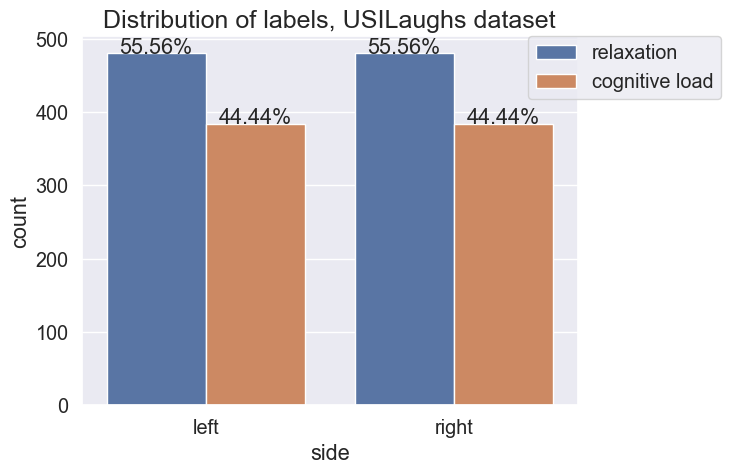

In [8]:
counts = get_labels_counts(labels_left, labels_right, ['relaxation', 'cognitive load'])
plot_binary_labels(
    counts=counts,
    title="Distribution of labels, USILaughs dataset",
    dataset_name="usilaughs",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [9]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)


/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-p

In [10]:
eda_features_names: list[str] = [
    "min_feat",
    "max_feat",
    "mean_feat",
    "std_feat",
    "dynamic_range_feat",
    "slope_feat",
    "absolute_slope_feat",
    "first_derivetive_mean_feat",
    "first_derivative_std_feat",
    "number_of_peaks_feat",
    "peaks_amplitude_feat",
]

In [11]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)


# Correlations

## Left vs Right features

### Events together

In [12]:
from scipy.stats import pearsonr
from numpy import nan_to_num

In [13]:
left_v_right_rho = {}
for i, feature in enumerate(eda_features_names):
    left_v_right_rho[feature] = pearsonr(
        nan_to_num(features_left, 0)[:, i], nan_to_num(features_right, 0)[:, i]
    ).correlation


In [14]:
left_v_right_rho = DataFrame(left_v_right_rho, index=["Person's Correlation Coefficient"])
left_v_right_rho.columns = [col.replace("_", " ") for col in left_v_right_rho.columns]

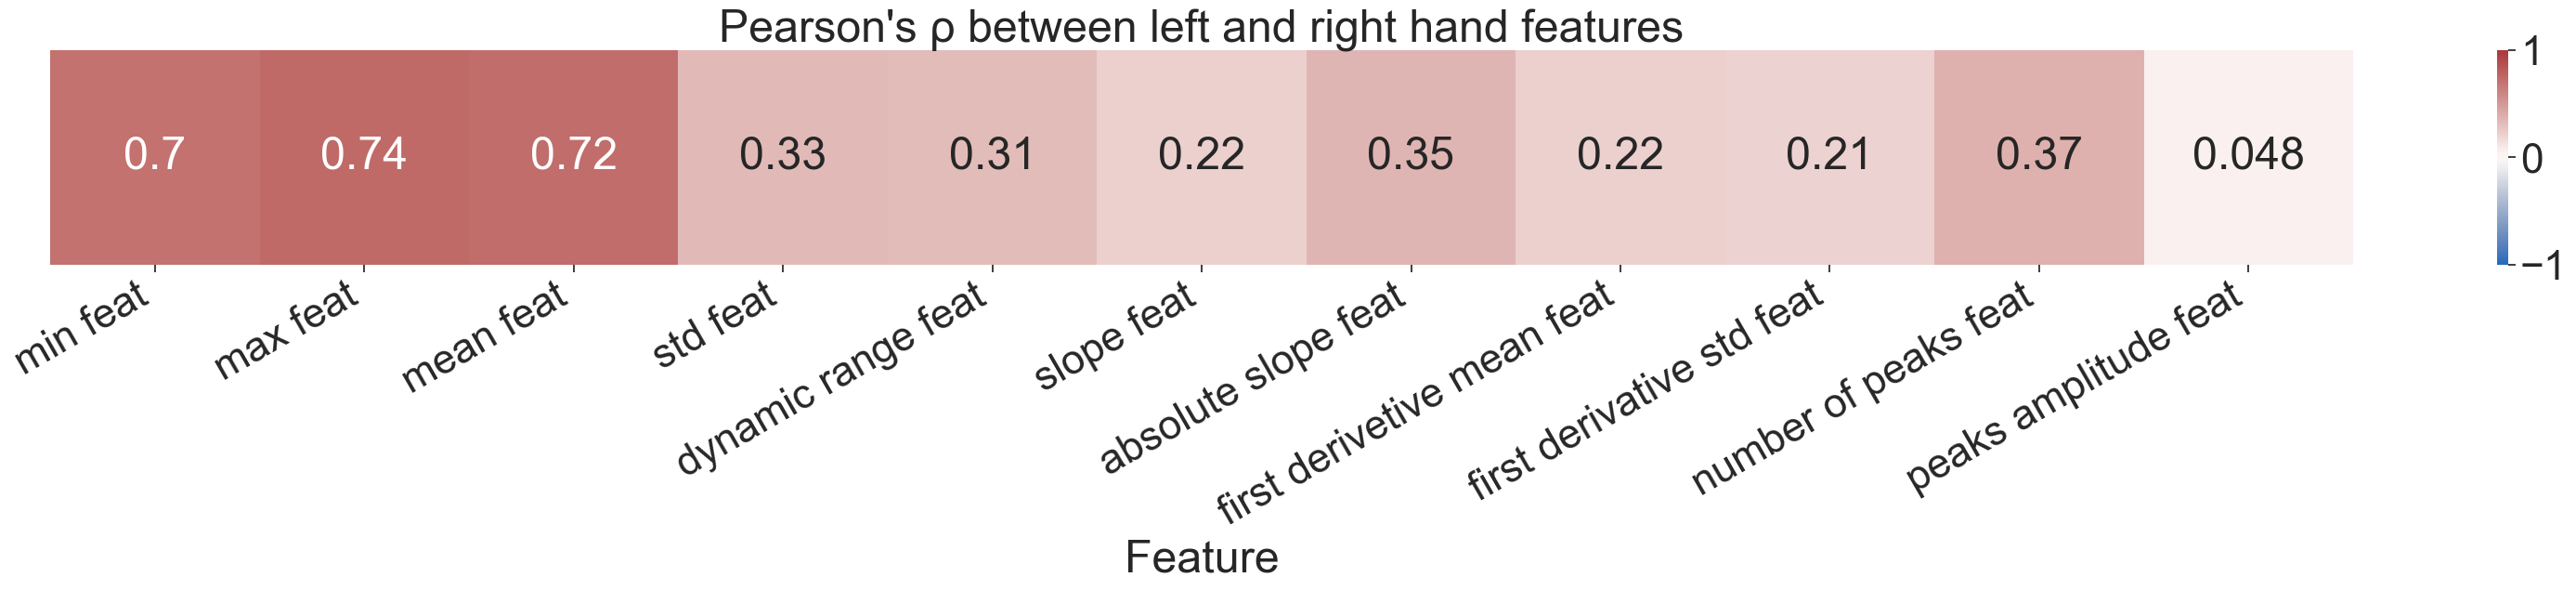

In [53]:
from seaborn import heatmap, set as set_style
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 3))
set_style(font_scale=2.9)
ax = heatmap(
        left_v_right_rho,
        xticklabels=left_v_right_rho.columns,
        vmax=1,
        vmin=-1,
        center=0,
        cmap="vlag",
        yticklabels=left_v_right_rho.index,
        annot=True,
    )

ax.tick_params(left=True, bottom=True)
plt.xticks(rotation=30, ha='right')
plt.yticks([], [])
plt.xlabel('Feature')
plt.ylabel('')
plt.title("Pearson's ρ between left and right hand features")
plt.savefig("../visualizations/left_right_both_events_pearson.pdf", bbox_inches="tight")
plt.show()

### Events separate

In [54]:
from scipy.stats import pearsonr
from numpy import nan_to_num

In [55]:
features_left_cognitive = features_left[labels_left == 1]
features_left_relaxation = features_left[labels_left == 0]

features_right_cognitive = features_right[labels_right == 1]
features_right_relaxation = features_right[labels_right == 0]

In [56]:
left_v_right_rho_separate_events = {}
for i, feature in enumerate(eda_features_names):
    left_v_right_rho_separate_events[feature] = {
        "cognitive load": pearsonr(
            nan_to_num(features_left_cognitive, 0)[:, i],
            nan_to_num(features_right_cognitive, 0)[:, i],
        ).correlation,
        "relaxation": pearsonr(
            nan_to_num(features_left_relaxation, 0)[:, i],
            nan_to_num(features_right_relaxation, 0)[:, i],
        ).correlation,
    }


In [57]:
left_v_right_rho_separate_events = DataFrame(left_v_right_rho_separate_events)
left_v_right_rho_separate_events.columns = [col.replace("_", " ") for col in left_v_right_rho_separate_events.columns]

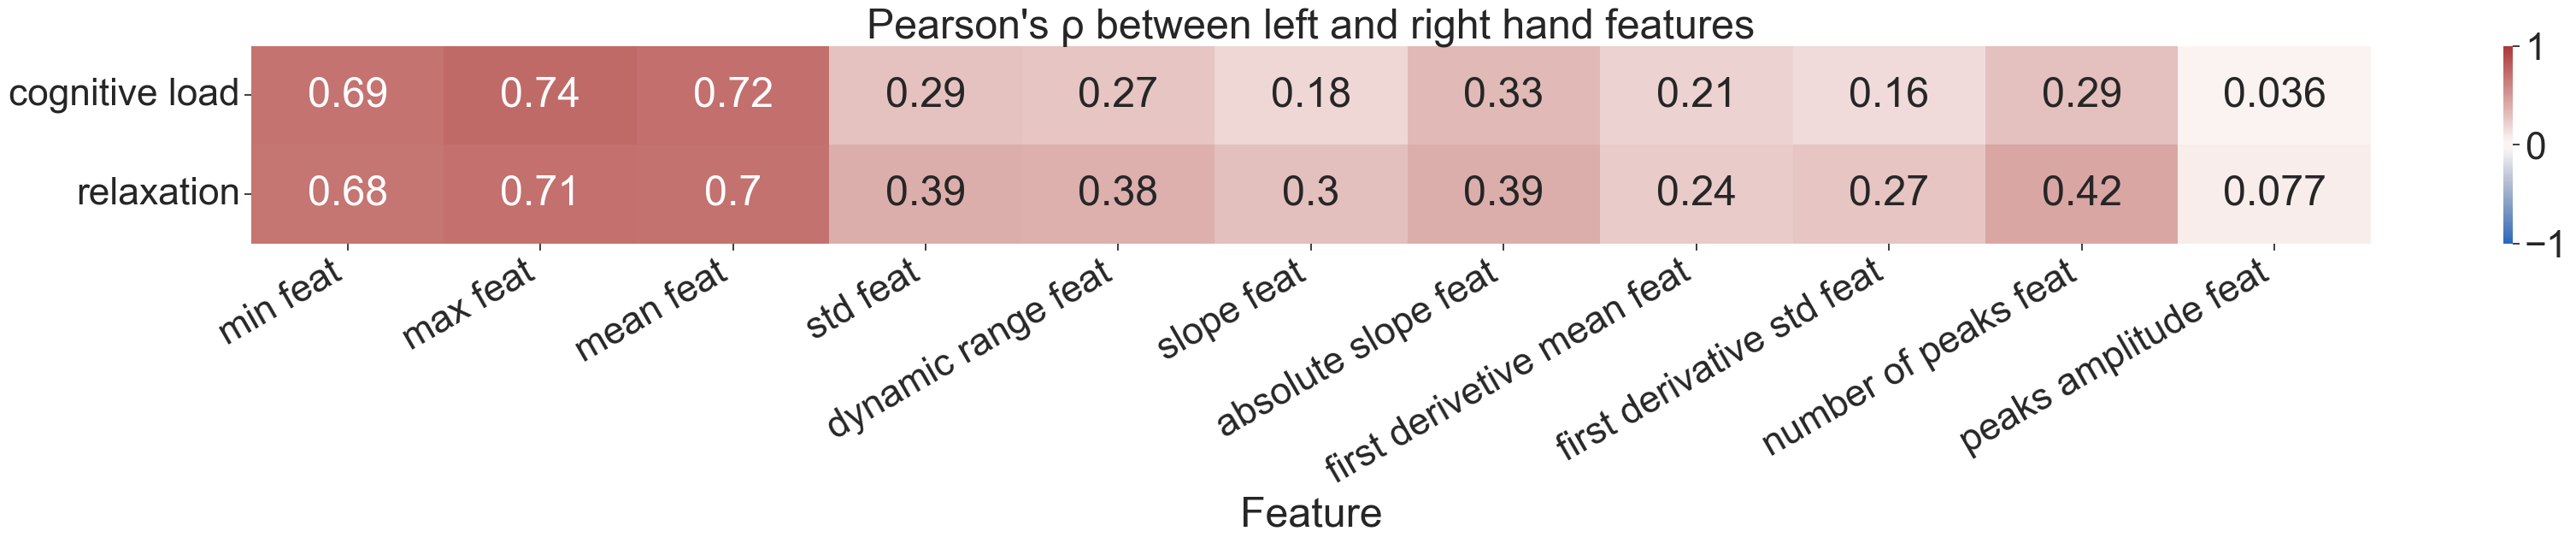

In [58]:
from seaborn import heatmap, set as set_style
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 3))
set_style(font_scale=2.9)
ax = heatmap(
        left_v_right_rho_separate_events,
        xticklabels=left_v_right_rho_separate_events.columns,
        vmax=1,
        vmin=-1,
        center=0,
        cmap="vlag",
        yticklabels=left_v_right_rho_separate_events.index,
        annot=True,
    )

ax.tick_params(left=True, bottom=True)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('Feature')
plt.ylabel('')
plt.title("Pearson's ρ between left and right hand features")
plt.savefig("../visualizations/left_right_separate_events_pearson.pdf", bbox_inches="tight")
plt.show()

### Event together, per user

In [59]:
from scipy.stats import pearsonr
from numpy import nan_to_num

In [60]:
users = list(set(groups_left.tolist()) & set(groups_right.tolist()))

In [61]:
left_v_right_rho_per_user = {}
for i, feature in enumerate(eda_features_names):
    left_v_right_rho_per_user[feature] = {
        user: pearsonr(
            nan_to_num(features_left[groups_left == user], 0)[:, i],
            nan_to_num(features_right[groups_right == user], 0)[:, i],
        ).correlation
        for user in users
    }


In [62]:
left_v_right_rho_per_user = DataFrame(left_v_right_rho_per_user)
left_v_right_rho_per_user.columns = [col.replace("_", " ") for col in left_v_right_rho_per_user.columns]
left_v_right_rho_per_user = left_v_right_rho_per_user.sort_index()

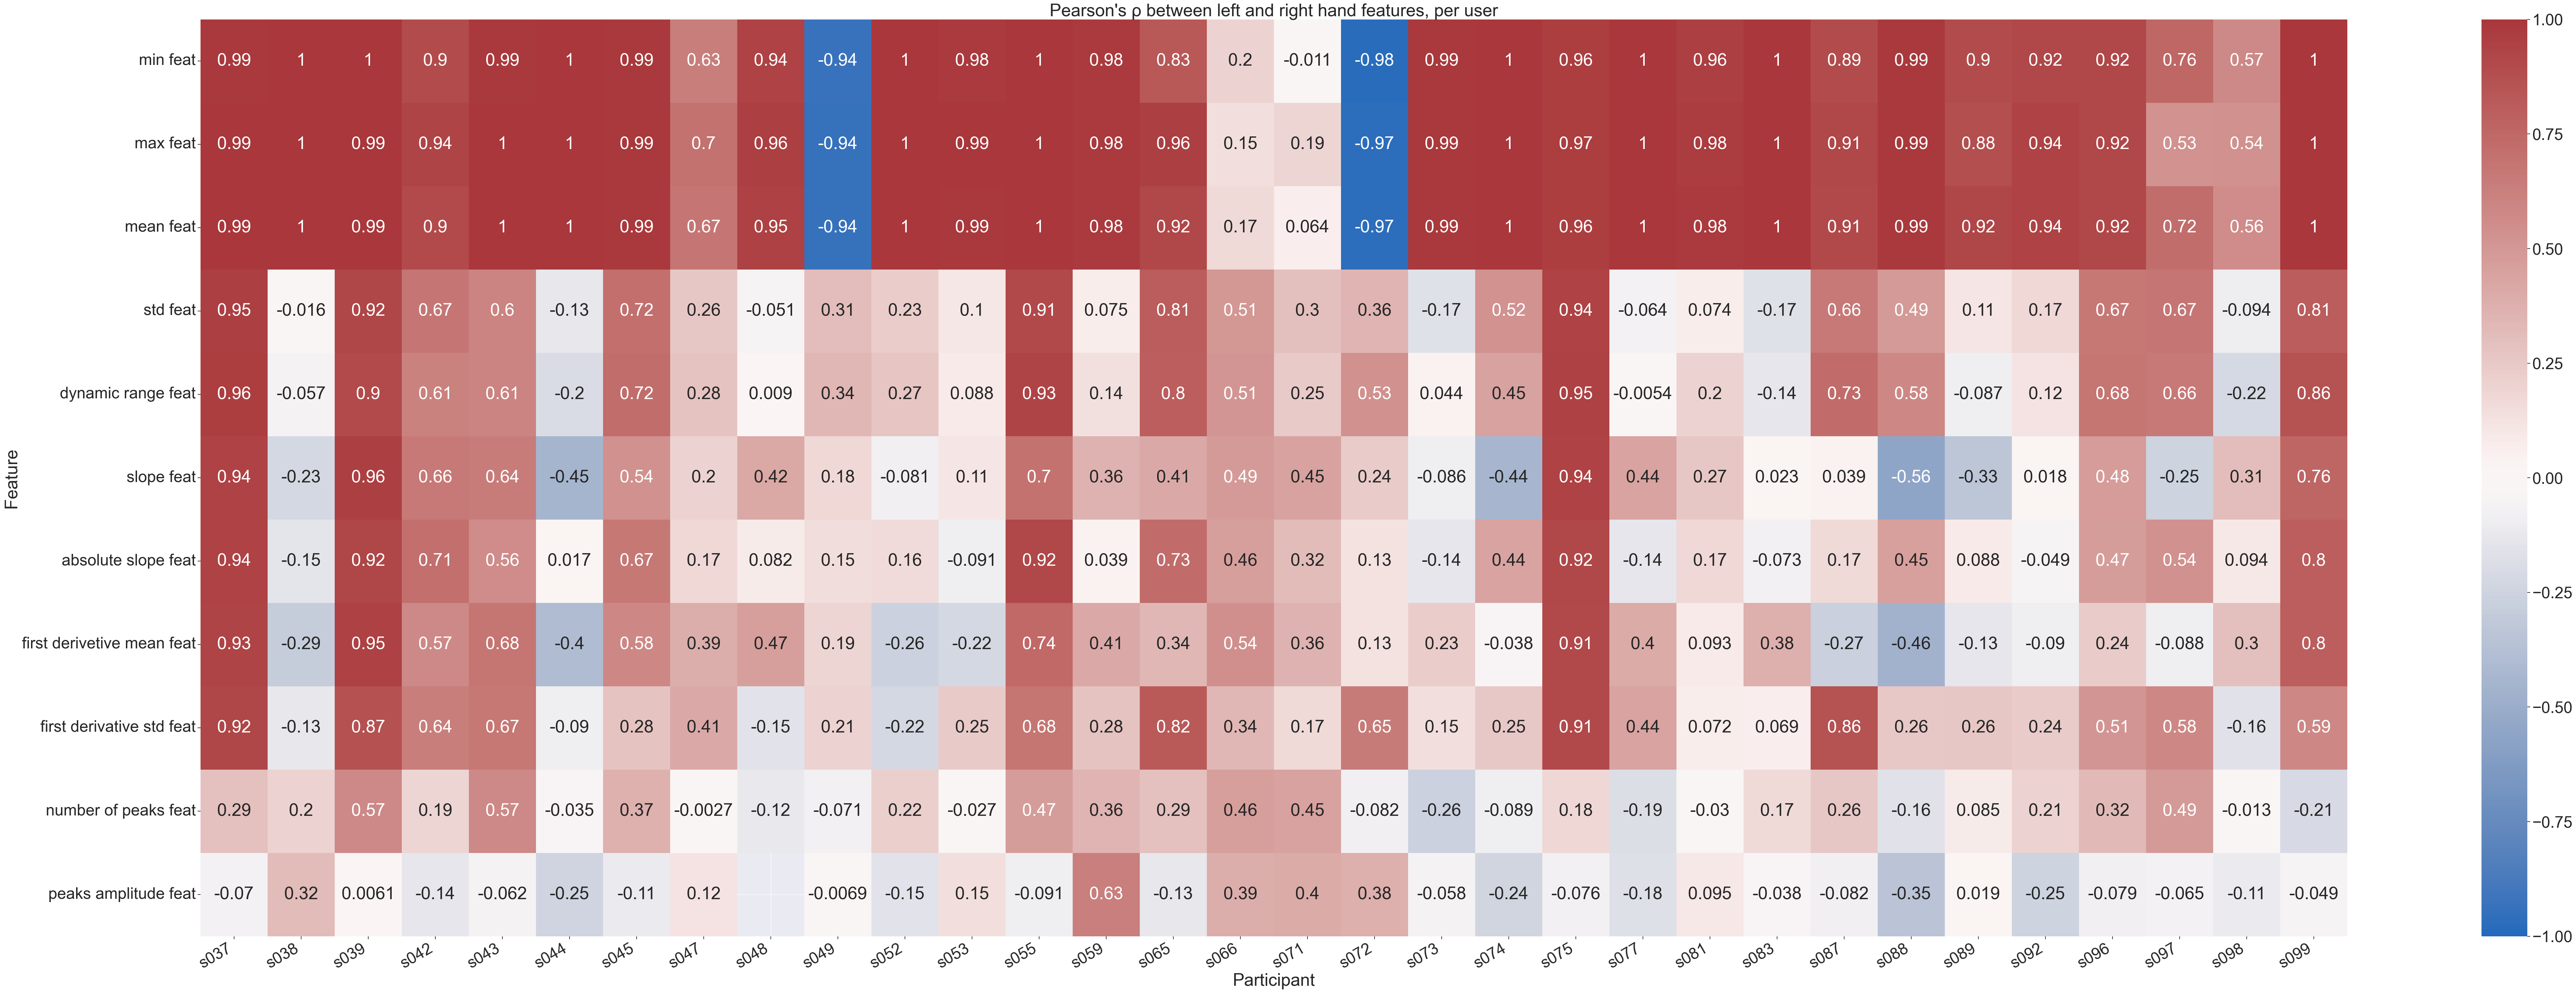

In [63]:
from seaborn import heatmap, set as set_style
import matplotlib.pyplot as plt

left_v_right_rho_per_user = left_v_right_rho_per_user.T
plt.figure(figsize=(len(left_v_right_rho_per_user.columns)*3, len(left_v_right_rho_per_user.index)*3))
set_style(font_scale=2.9)
ax = heatmap(
        left_v_right_rho_per_user,
        xticklabels=left_v_right_rho_per_user.columns,
        vmax=1,
        vmin=-1,
        center=0,
        cmap="vlag",
        yticklabels=left_v_right_rho_per_user.index,
        annot=True,
    )

ax.tick_params(left=True, bottom=True)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0, ha='right')
plt.ylabel('Feature')
plt.xlabel('Participant')
plt.title("Pearson's ρ between left and right hand features, per user")
plt.savefig("../visualizations/left_right_both_events_pearson_per_user.pdf", bbox_inches="tight")
plt.show()

### Separate events, per user

In [64]:
from scipy.stats import pearsonr
from numpy import nan_to_num

In [65]:
users = list(set(groups_left.tolist()) & set(groups_right.tolist()))

features_left_cognitive = features_left[labels_left == 1]
groups_left_cognitive = groups_left[labels_left == 1]

features_left_relaxation = features_left[labels_left == 0]
groups_left_relaxation = groups_left[labels_left == 0]


features_right_cognitive = features_right[labels_right == 1]
groups_right_cognitive = groups_right[labels_right == 1]

features_right_relaxation = features_right[labels_right == 0]
groups_right_relaxation = groups_right[labels_right == 0]

In [66]:
left_v_right_rho_separate_events_per_user = {}
for i, feature in enumerate(eda_features_names):
    aux_dict = {}
    for user in users:
        aux_dict[(user, "cognitive load")] = pearsonr(
            nan_to_num(features_left_cognitive[groups_left_cognitive == user], 0)[:, i],
            nan_to_num(features_right_cognitive[groups_right_cognitive == user], 0)[
                :, i
            ],
        ).correlation
        aux_dict[(user, "relaxation")] = pearsonr(
            nan_to_num(features_left_relaxation[groups_left_relaxation == user], 0)[
                :, i
            ],
            nan_to_num(features_right_relaxation[groups_right_relaxation == user], 0)[
                :, i
            ],
        ).correlation

    left_v_right_rho_separate_events_per_user[feature] = aux_dict
    del aux_dict


In [67]:
from pandas import MultiIndex

left_v_right_rho_separate_events_per_user = DataFrame(
    left_v_right_rho_separate_events_per_user
)
left_v_right_rho_separate_events_per_user.columns = [
    col.replace("_", " ") for col in left_v_right_rho_separate_events_per_user.columns
]

left_v_right_rho_separate_events_per_user.index = MultiIndex.from_tuples(
    left_v_right_rho_separate_events_per_user.index
)
left_v_right_rho_separate_events_per_user = (
    left_v_right_rho_separate_events_per_user.sort_index()
)


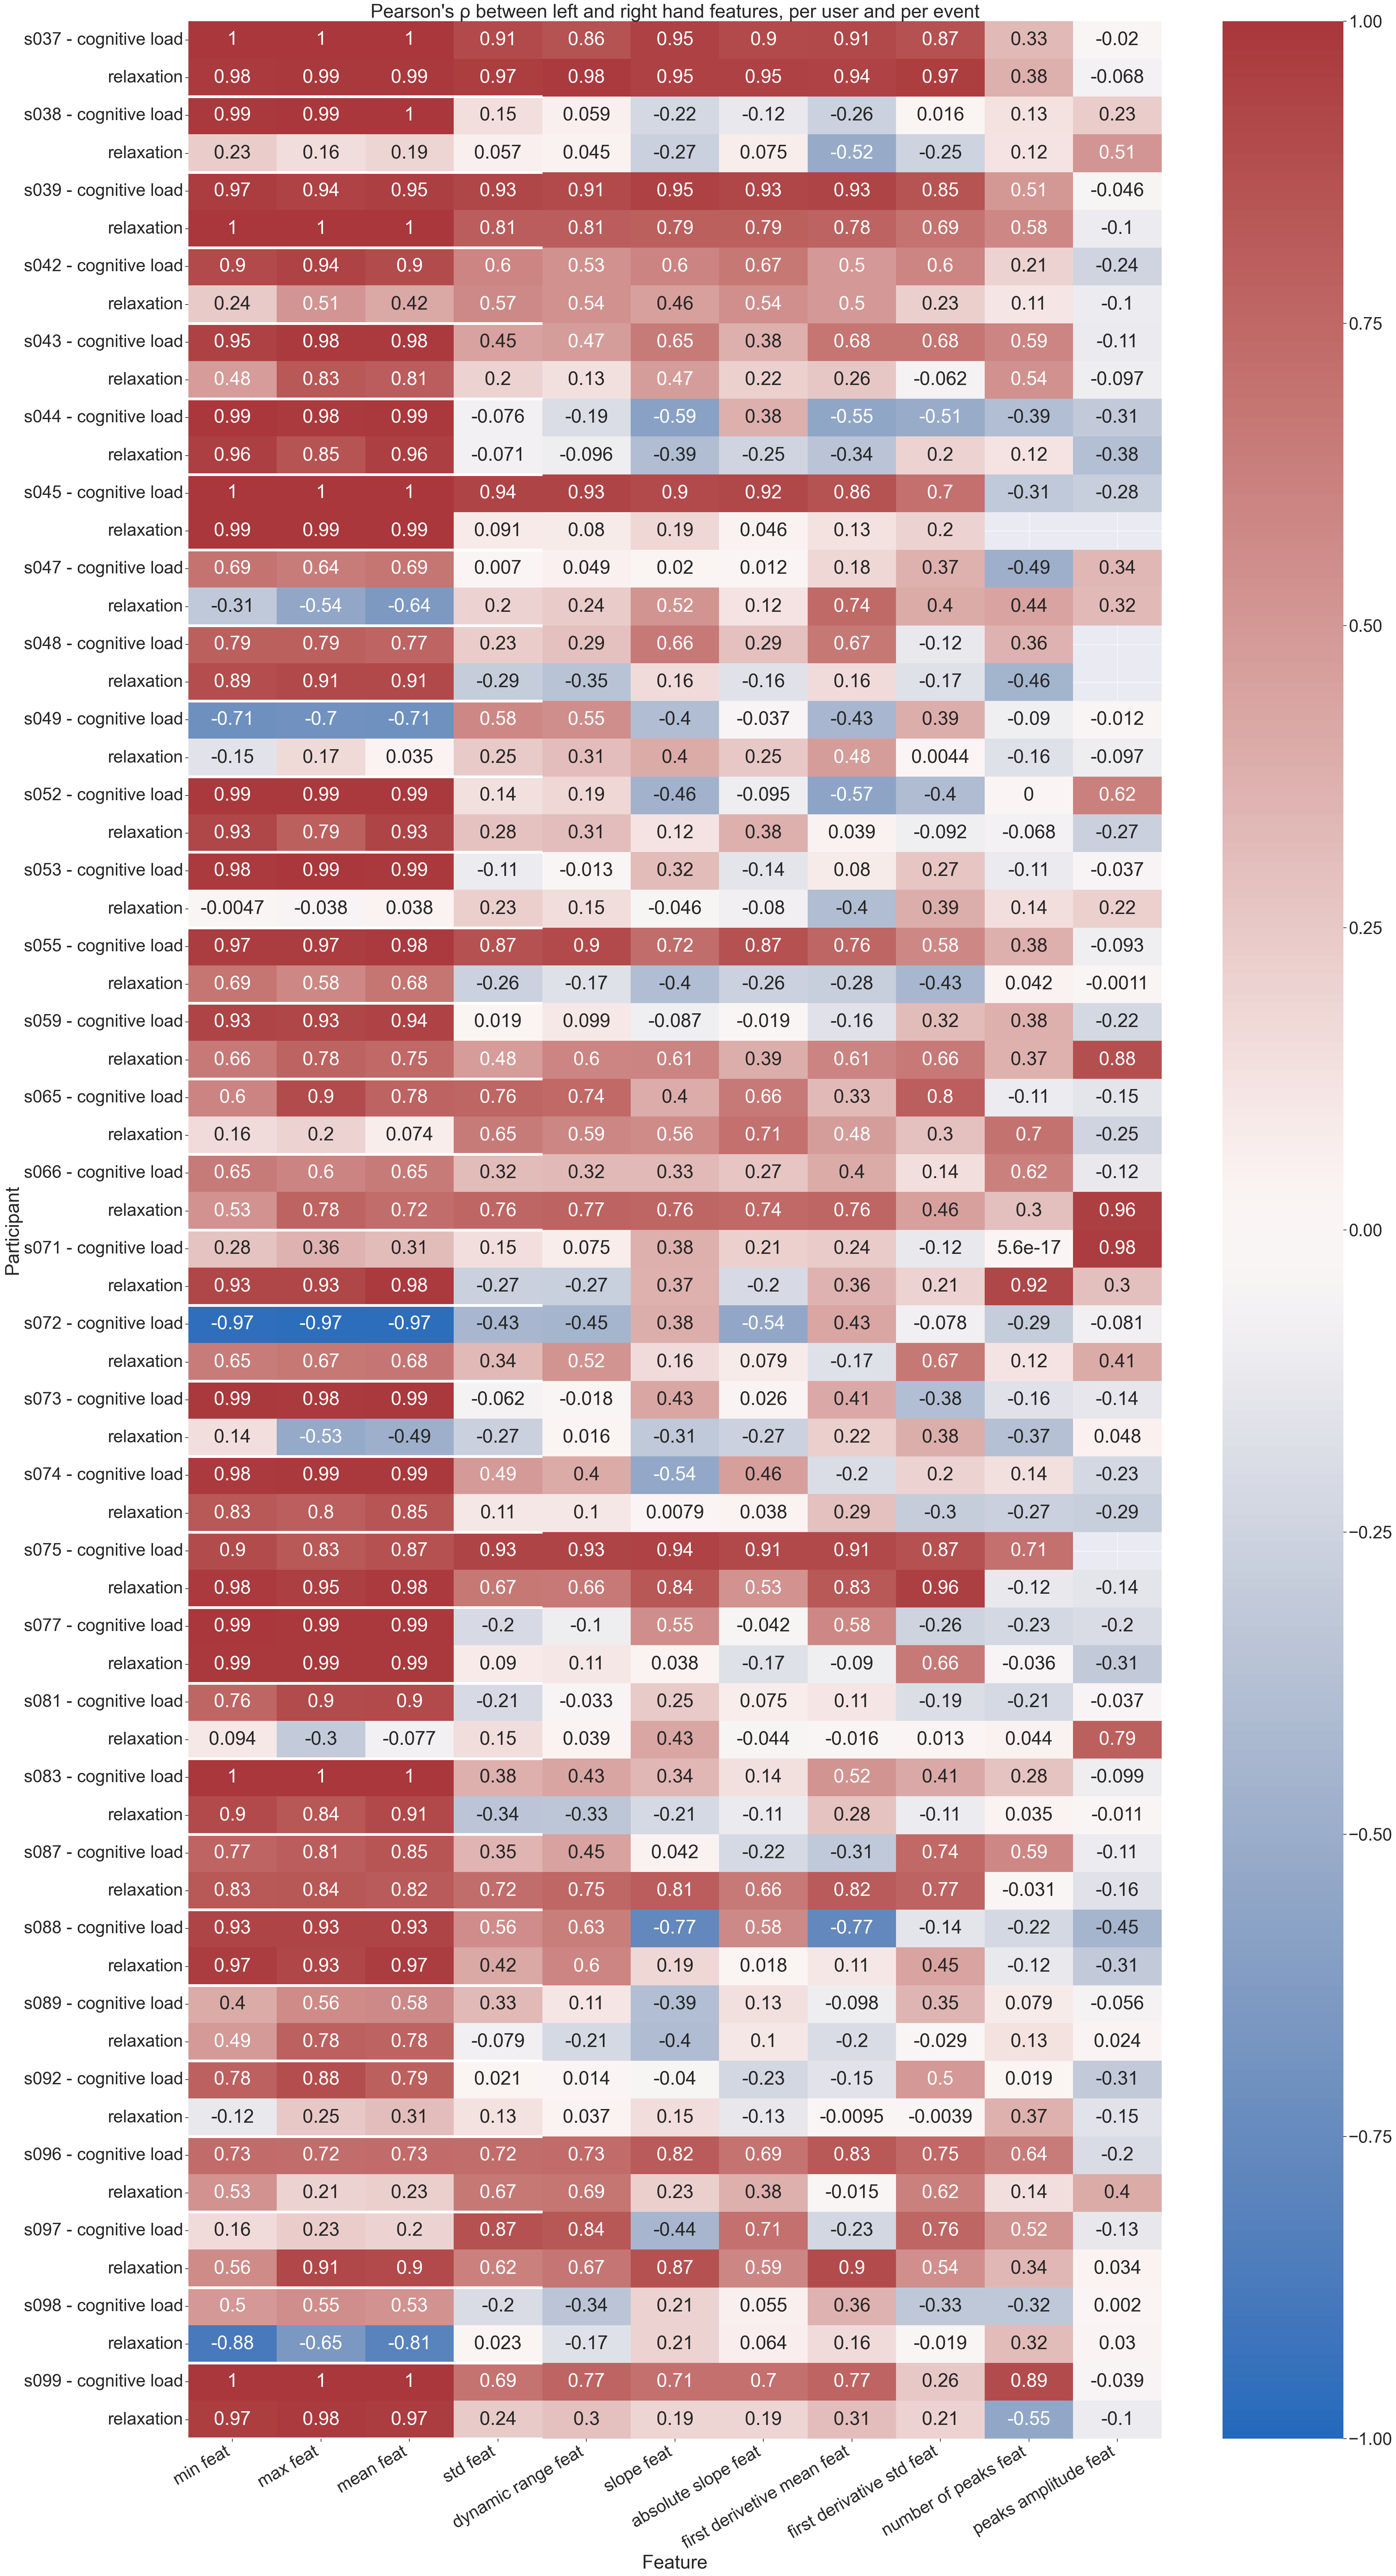

In [68]:
from seaborn import heatmap, set as set_style
import matplotlib.pyplot as plt
from collections import OrderedDict

plt.figure(figsize=(40, 80))
set_style(font_scale=2.9)
ax = heatmap(
        left_v_right_rho_separate_events_per_user,
        xticklabels=left_v_right_rho_separate_events_per_user.columns,
        vmax=1,
        vmin=-1,
        center=0,
        cmap="vlag",
        yticklabels=left_v_right_rho_separate_events_per_user.index,
        annot=True,
    )

ax.tick_params(left=True, bottom=True)
plt.xticks(rotation=30, ha='right')

ylabel_mapping = OrderedDict()
for user, event in left_v_right_rho_separate_events_per_user.index:
    ylabel_mapping.setdefault(user, [])
    ylabel_mapping[user].append(event)
    
hline = []
new_ylabels = []
for user, event_list in ylabel_mapping.items():
    event_list[0] = "{} - {}".format(user, event_list[0])
    new_ylabels.extend(event_list)
    
    if hline:
        hline.append(len(event_list) + hline[-1])
    else:
        hline.append(len(event_list))


ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth=5)
ax.set_yticklabels(new_ylabels)
plt.xlabel('Feature')
plt.ylabel('Participant')
plt.title("Pearson's ρ between left and right hand features, per user and per event")
plt.savefig("../visualizations/left_right_both_events_pearson_per_user_per_event.pdf", bbox_inches="tight")
plt.show()

## Features vs Labels

In [69]:
from scipy.stats import pearsonr
from numpy import nan_to_num

### All users

In [70]:
features_vs_label = {}
for i, feature in enumerate(eda_features_names):
    features_vs_label[feature] = {
        "left": pearsonr(
            nan_to_num(features_left, 0)[:, i], nan_to_num(labels_left, 0)
        ).correlation,
        "right": pearsonr(
            nan_to_num(features_right, 0)[:, i], nan_to_num(labels_right, 0)
        ).correlation,
    }


In [71]:
features_vs_label = DataFrame(features_vs_label)
features_vs_label.columns = [col.replace("_", " ") for col in features_vs_label.columns]


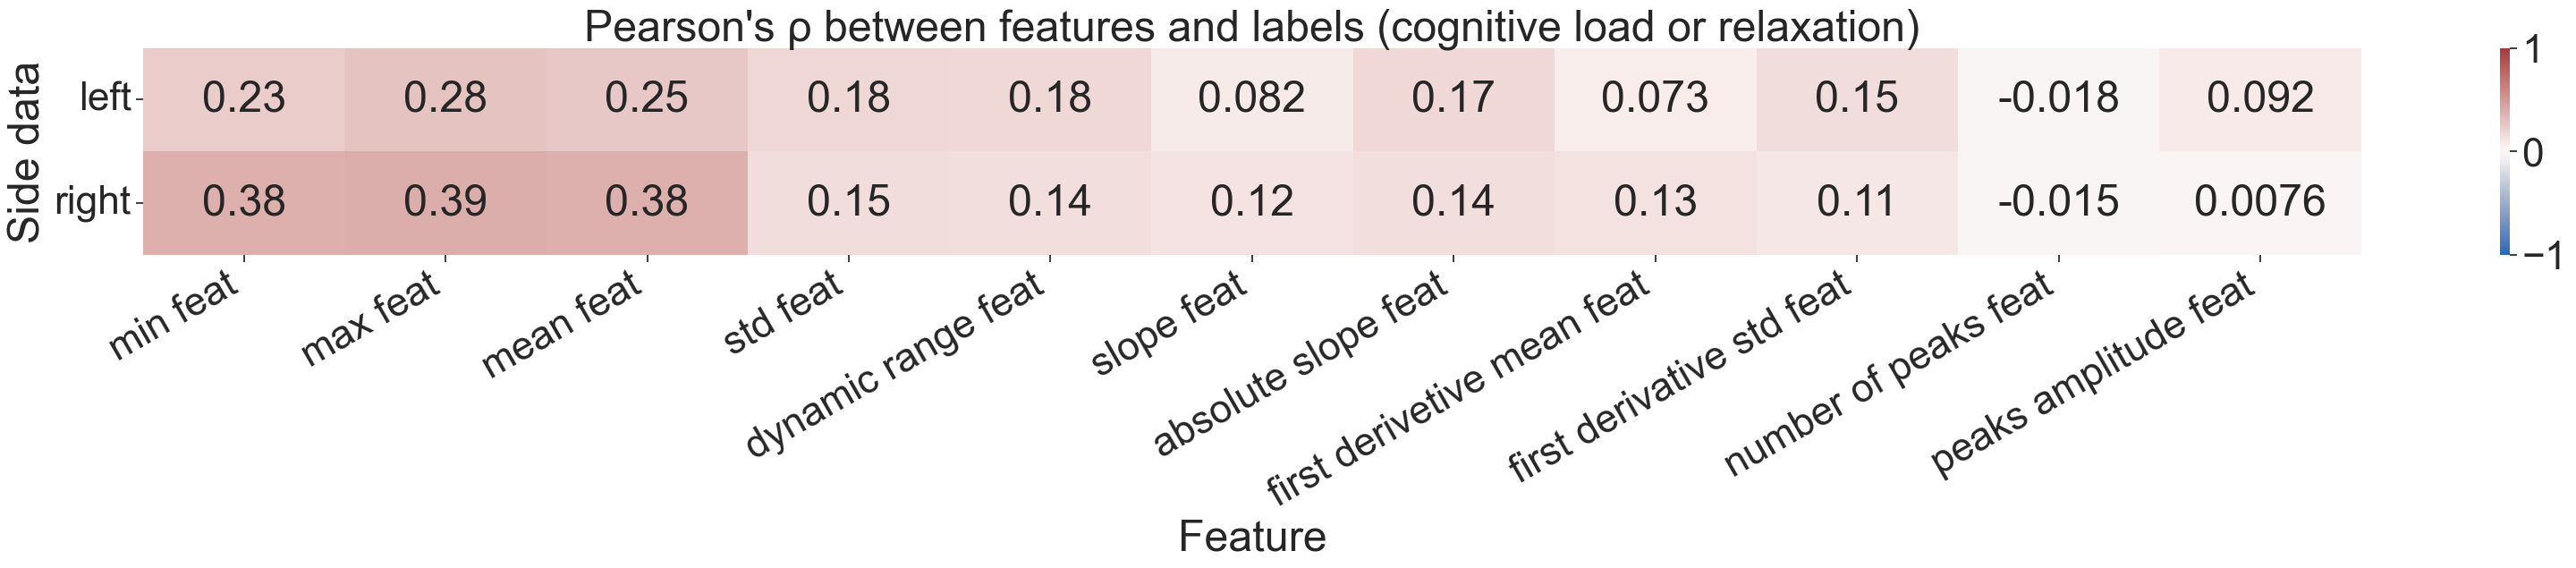

In [72]:
from seaborn import heatmap, set as set_style
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 3))
set_style(font_scale=2.9)
ax = heatmap(
        features_vs_label,
        xticklabels=features_vs_label.columns,
        vmax=1,
        vmin=-1,
        center=0,
        cmap="vlag",
        yticklabels=features_vs_label.index,
        annot=True,
    )

ax.tick_params(left=True, bottom=True)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('Feature')
plt.ylabel('Side data')
plt.title("Pearson's ρ between features and labels (cognitive load or relaxation)")
plt.savefig("../visualizations/features_labels_correlation.pdf", bbox_inches="tight")
plt.show()

### Per user

In [73]:
from scipy.stats import pearsonr
from numpy import nan_to_num

In [74]:
users = list(set(groups_left.tolist()) & set(groups_right.tolist()))

In [75]:
features_vs_label_per_user = {}
for i, feature in enumerate(eda_features_names):
    aux_dict = {}
    for user in users:
        aux_dict[(user, "left")] = pearsonr(
            nan_to_num(features_left[groups_left == user], 0)[:, i],
            nan_to_num(labels_left[groups_right == user], 0),
        ).correlation
        aux_dict[(user, "right")] = pearsonr(
            nan_to_num(features_right[groups_right == user], 0)[
                :, i
            ],
            nan_to_num(labels_right[groups_right == user], 0),
        ).correlation

    features_vs_label_per_user[feature] = aux_dict
    del aux_dict


In [76]:
from pandas import MultiIndex

features_vs_label_per_user = DataFrame(features_vs_label_per_user)
features_vs_label_per_user.columns = [
    col.replace("_", " ") for col in features_vs_label_per_user.columns
]

features_vs_label_per_user.index = MultiIndex.from_tuples(
    features_vs_label_per_user.index
)
features_vs_label_per_user = features_vs_label_per_user.sort_index()


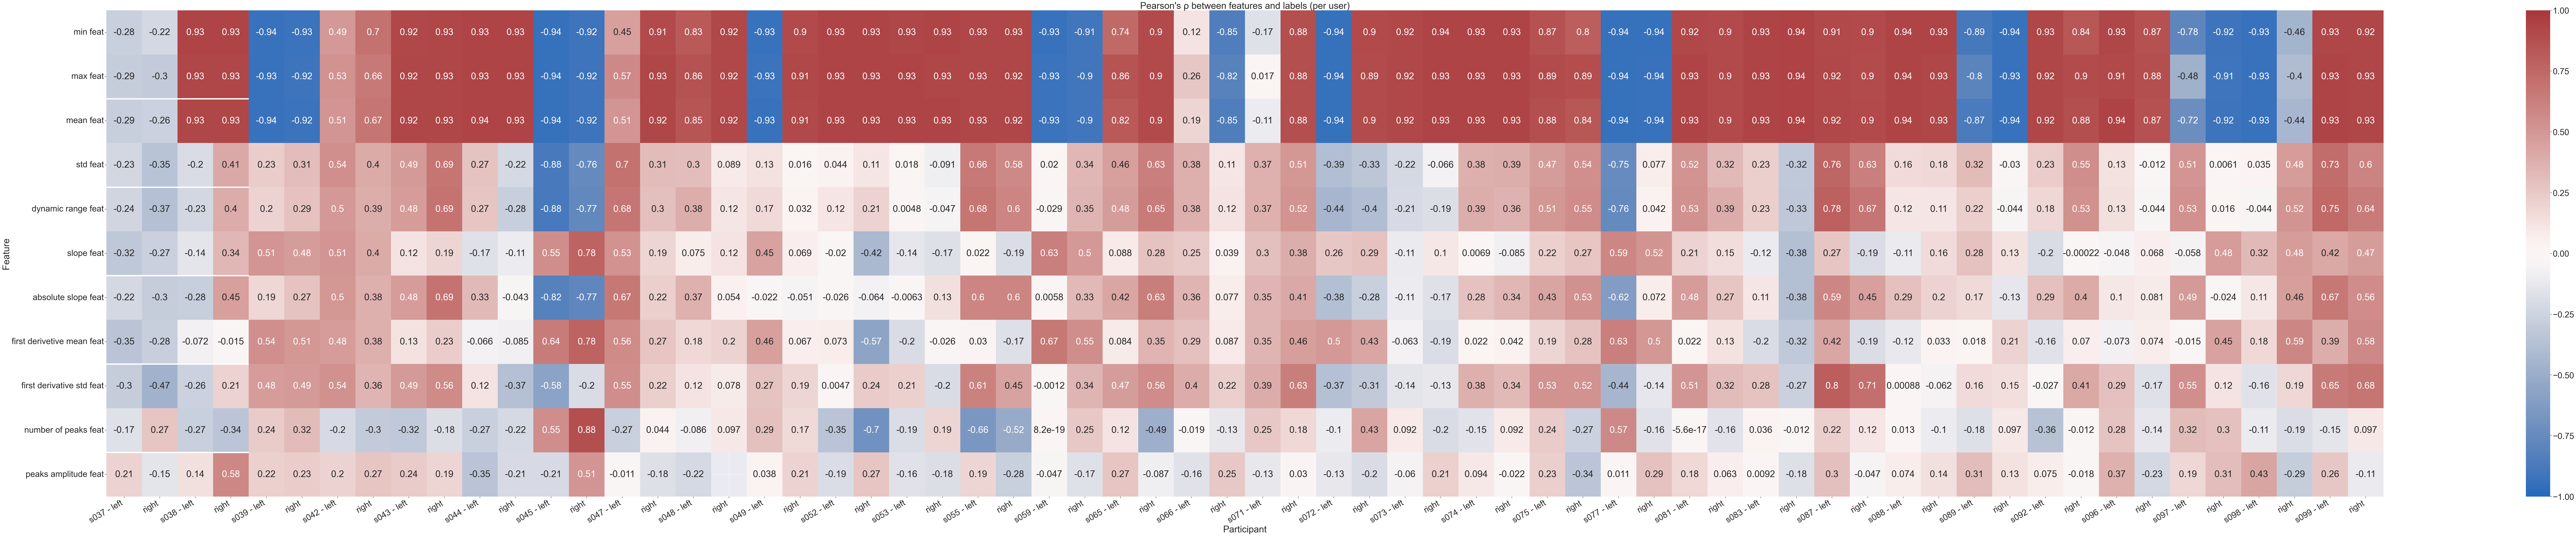

In [77]:
from seaborn import heatmap, set as set_style
import matplotlib.pyplot as plt
from collections import OrderedDict

features_vs_label_per_user = features_vs_label_per_user.T
plt.figure(figsize=(len(features_vs_label_per_user.columns)*3, len(features_vs_label_per_user.index)*3))
set_style(font_scale=2.9)
ax = heatmap(
        features_vs_label_per_user,
        xticklabels=features_vs_label_per_user.columns,
        vmax=1,
        vmin=-1,
        center=0,
        cmap="vlag",
        yticklabels=features_vs_label_per_user.index,
        annot=True,
    )

ax.tick_params(left=True, bottom=True)
plt.xticks(rotation=30, ha='right')

xlabel_mapping = OrderedDict()
for user, event in features_vs_label_per_user.columns:
    xlabel_mapping.setdefault(user, [])
    xlabel_mapping[user].append(event)
    
hline = []
new_ylabels = []
for user, event_list in xlabel_mapping.items():
    event_list[0] = "{} - {}".format(user, event_list[0])
    new_ylabels.extend(event_list)
    
    if hline:
        hline.append(len(event_list) + hline[-1])
    else:
        hline.append(len(event_list))


ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth=5)
ax.set_xticklabels(new_ylabels)
plt.ylabel('Feature')
plt.xlabel('Participant')
plt.title("Pearson's ρ between features and labels (per user)")
plt.savefig("../visualizations/features_labels_correlation_per_user.pdf", bbox_inches="tight")
plt.show()

# Data Distribution Analysis

## All events

In [78]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
random_state = 42

In [79]:
tsne_left = TSNE(n_components=2, random_state=random_state).fit_transform(features_left)
tsne_right = TSNE(n_components=2, random_state=random_state).fit_transform(features_right)

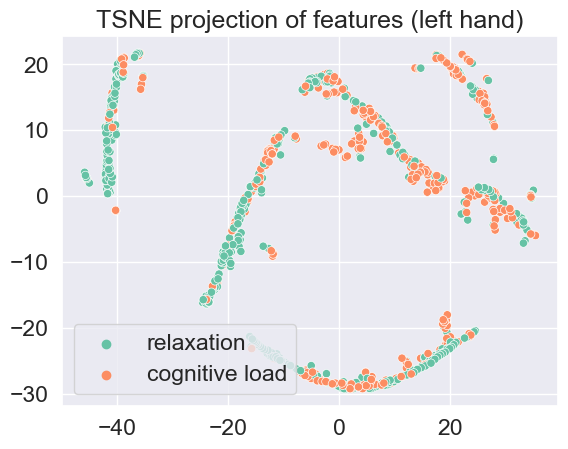

In [80]:
sns.set(font_scale=1.5)
sns.scatterplot(
    x=tsne_left[:, 0],
    y=tsne_left[:, 1],
    hue=["cognitive load" if label == 1 else "relaxation" for label in labels_left],
    palette="Set2",
)
plt.title('TSNE projection of features (left hand)')
plt.show()

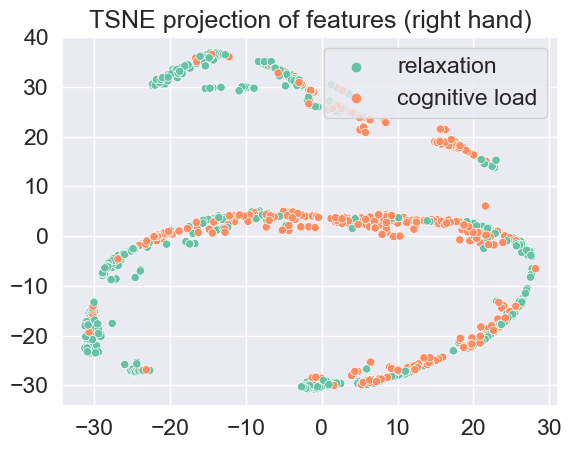

In [81]:
sns.set(font_scale=1.5)
sns.scatterplot(
    x=tsne_right[:, 0],
    y=tsne_right[:, 1],
    hue=["cognitive load" if label == 1 else "relaxation" for label in labels_right],
    palette="Set2",
)
plt.title('TSNE projection of features (right hand)')
plt.show()

In [82]:
pca_left = PCA(n_components=2, random_state=random_state).fit_transform(features_left)
pca_right = PCA(n_components=2, random_state=random_state).fit_transform(features_right)

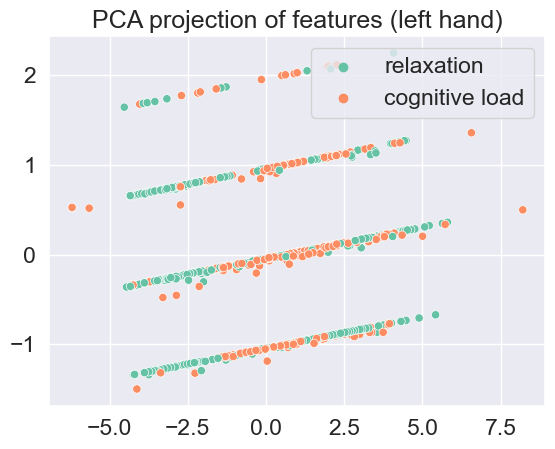

In [83]:
sns.set(font_scale=1.5)
sns.scatterplot(
    x=pca_left[:, 0],
    y=pca_left[:, 1],
    hue=["cognitive load" if label == 1 else "relaxation" for label in labels_left],
    palette="Set2",
)
plt.title('PCA projection of features (left hand)')
plt.show()

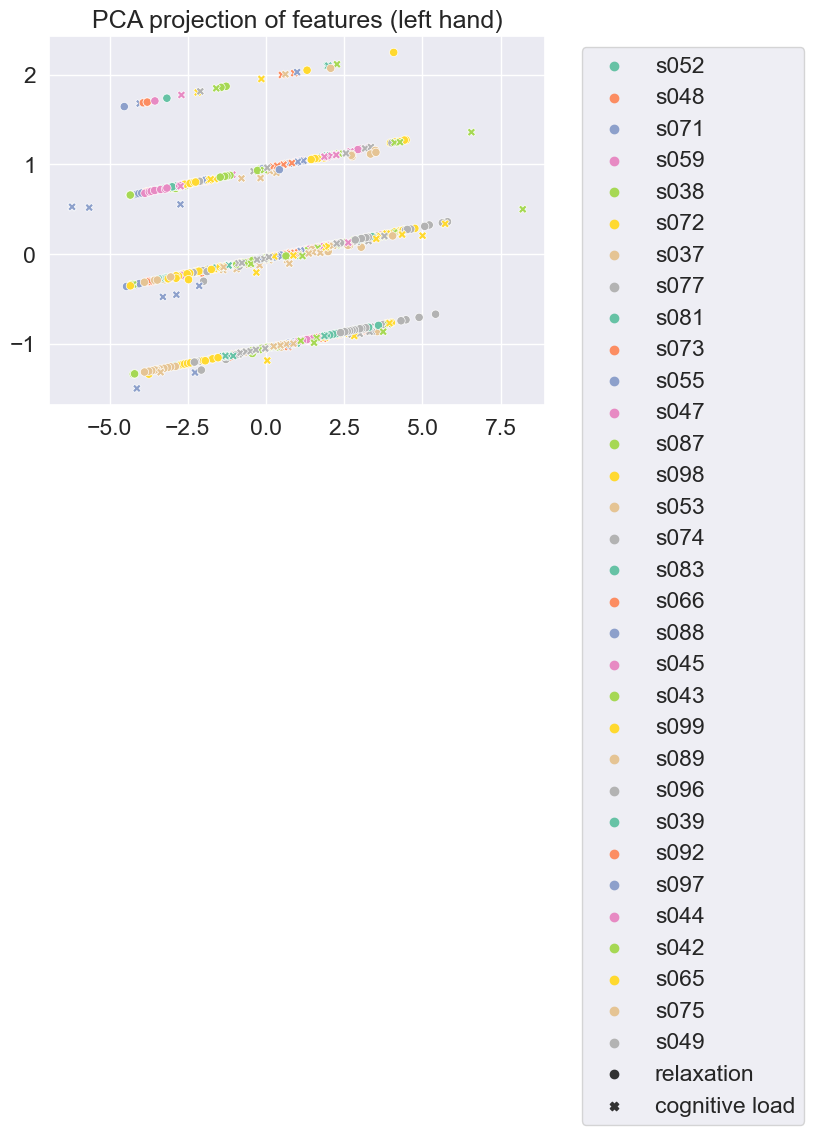

In [84]:
sns.set(font_scale=1.5)
sns.scatterplot(
    x=pca_left[:, 0],
    y=pca_left[:, 1],
    hue=groups_left,
    style=["cognitive load" if label == 1 else "relaxation" for label in labels_left],
    palette="Set2",
)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('PCA projection of features (left hand)')
plt.show()

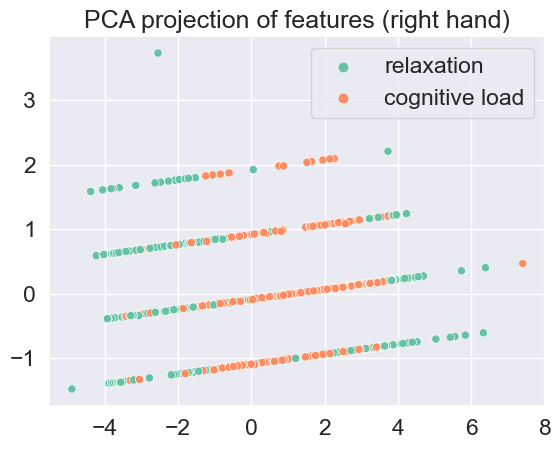

In [85]:
sns.set(font_scale=1.5)
sns.scatterplot(
    x=pca_right[:, 0],
    y=pca_right[:, 1],
    hue=["cognitive load" if label == 1 else "relaxation" for label in labels_right],
    palette="Set2",
)
plt.title('PCA projection of features (right hand)')
plt.show()

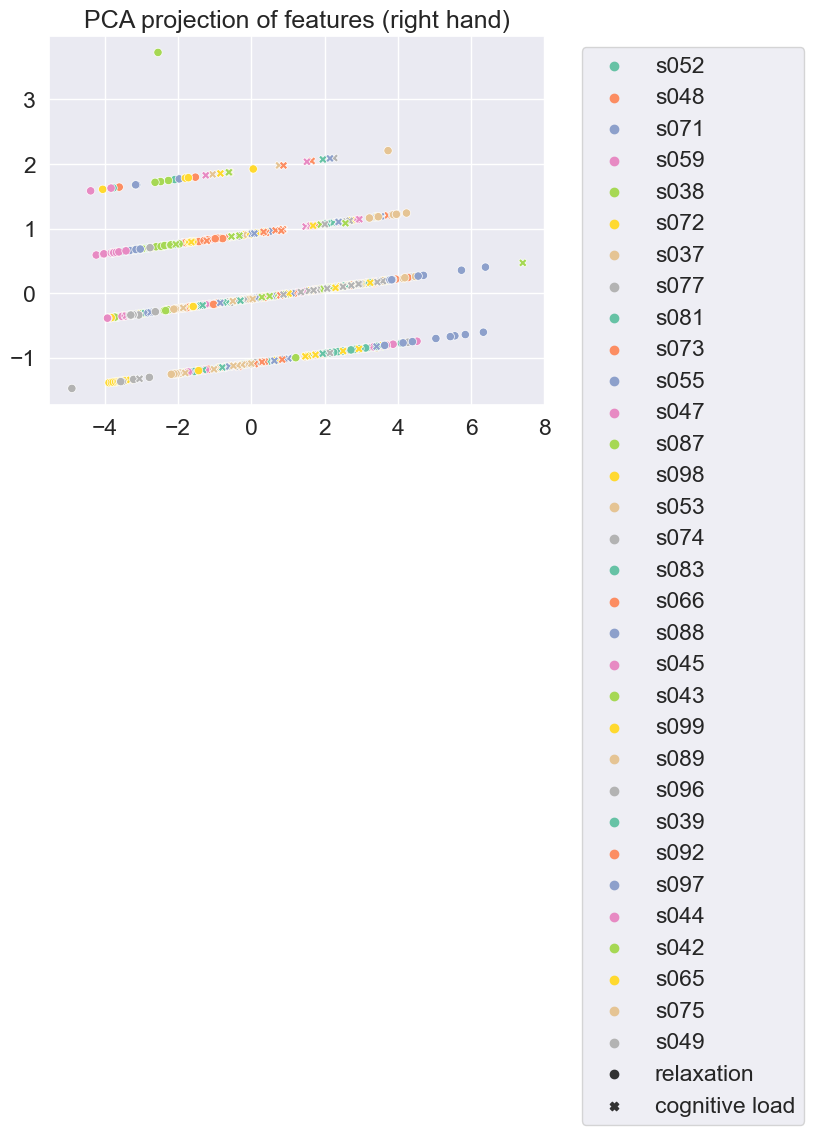

In [86]:
sns.set(font_scale=1.5)
sns.scatterplot(
    x=pca_right[:, 0],
    y=pca_right[:, 1],
    hue=groups_right,
    style=["cognitive load" if label == 1 else "relaxation" for label in labels_right],
    palette="Set2",
)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('PCA projection of features (right hand)')
plt.show()

## Interactive

### PCA

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
random_state = 42

In [ ]:
import plotly.express as px
from numpy import concatenate

In [ ]:
features_tot = concatenate([features_left, features_right], axis=0)
pca_tot = PCA(n_components=2, random_state=random_state).fit_transform(features_tot)
side = ["left"] * len(features_left) + ["right"] * len(features_right)

In [ ]:
pca_tot = DataFrame(pca_tot, columns=["x", "y"])
pca_tot['side'] = side
pca_tot['user'] = concatenate([groups_left, groups_right], axis=0)
pca_tot['label'] = concatenate([labels_left, labels_right], axis=0)
pca_tot['label'] = pca_tot['label'].apply(lambda x: "cognitive load" if x == 1 else "relaxation")

In [ ]:
fig = px.scatter(
    data_frame=pca_tot,
    x="x",
    y="y",
    symbol="label",
    color="side",
    hover_name="user",
    title="PCA projection of features (both hands)",
    width=1000, height=800
)
fig.write_html("../visualizations/pca_projection.html")


## TSNE

In [110]:
features_tot = concatenate([features_left, features_right], axis=0)
tsne_tot = TSNE(n_components=2, random_state=random_state).fit_transform(features_tot)
side = ["left"] * len(tsne_left) + ["right"] * len(tsne_right)

In [111]:
tsne_tot = DataFrame(tsne_tot, columns=["x", "y"])
tsne_tot['side'] = side
tsne_tot['user'] = concatenate([groups_left, groups_right], axis=0)
tsne_tot['label'] = concatenate([labels_left, labels_right], axis=0)
tsne_tot['label'] = tsne_tot['label'].apply(lambda x: "cognitive load" if x == 1 else "relaxation")

In [114]:
px.scatter(
    data_frame=tsne_tot,
    x="x",
    y="y",
    symbol="label",
    color="side",
    hover_name="user",
    title="TSNE projection of features (both hands)",
    width=1000, height=800
)
